# Marginal and Multilevel Linear Modeling 

In a previous post, we dug into the NHANES national health and nutrition data set to answer some interesting questions using confidence intervals and hypothesis tests (https://crawstat.com/2020/06/09/uninsured-racial-disparity-blood-pressure-gender-smoker-diffs/). Here, we'll look at predicting systolic blood pressure by fitting, diagnosing, and comparing linear regression models, first with ordinary least squares (OLS) adopting the simplifying assumption of independent samples, and then with marginal and multilevel models taking into account NHANES' geographic cluster sampling design. 

**Part 1**: we'll fit and diagnose an OLS regression of systolic blood pressure on 5 independent variables assuming fully independent samples. 

**Part 2**: we'll visualize and assess mean structure by plotting systolic blood pressure against select focus variables. 

**Part 3**: we'll visualize and assess variance structure by generating a mean-variance relationship (residuals vs. fitted values), partial residual plots, and an added variable plot.  

**Part 4**: we'll take into account _within-cluster_ dependencies, using a marginal linear model, in this case, a generalized estimating equation (GEE).

**Part 5**: we'll take into account _between-cluster_ differences, using a multilevel linear model (aka hierarchical or mixed effects model).

We'll walk through how to fit linear models and diagnose and compare them by interpreting parameters, standard errors, variance, and residual plots. We'll also see within-cluster dependencies and between-cluster variance at work and how accounting for them helps us develop more accurate and meaningful models. Let's dig in.    

## Part 1: Linear Regression on 5 Covariates Assuming Fully Independent Samples

In [35]:
# Import relevant libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t
import numpy as np
import scipy.stats.distributions as dist
from IPython.display import display, HTML

In [36]:
# Read the data set and have a look at the first few rows to a get a feel for it
pd.set_option("display.max_columns", 100)
da = pd.read_csv("https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv")
da.head(5)

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDMARTL,DMDHHSIZ,WTINT2YR,SDMVPSU,SDMVSTRA,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,1.0,2,134671.37,1,125,4.39,128.0,70.0,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,3.0,1,24328.56,1,125,1.32,146.0,88.0,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,1.0,2,12400.01,1,131,1.51,138.0,46.0,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,6.0,1,102718.00,1,131,5.00,132.0,72.0,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,3.0,5,17627.67,2,126,1.23,100.0,70.0,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [37]:
# Check the column headings
da.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')

In [38]:
# Check the dimensions of the dataframe, this one has 5,735 rows and 28 columns
da.shape

(5735, 28)

In [39]:
# Check number of null values by variable
da.isnull().sum()

SEQN           0
ALQ101       527
ALQ110      4004
ALQ130      2356
SMQ020         0
RIAGENDR       0
RIDAGEYR       0
RIDRETH1       0
DMDCITZN       1
DMDEDUC2     261
DMDMARTL     261
DMDHHSIZ       0
WTINT2YR       0
SDMVPSU        0
SDMVSTRA       0
INDFMPIR     601
BPXSY1       334
BPXDI1       334
BPXSY2       200
BPXDI2       200
BMXWT         69
BMXHT         62
BMXBMI        73
BMXLEG       390
BMXARML      308
BMXARMC      308
BMXWAIST     367
HIQ210      1003
dtype: int64

In [40]:
# Create new gender column using more easily interpretable variables (instead of numeric responses)
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

# Create new ethnicity column using more easily interpretable variables (instead of numeric responses)
da["RIDRETH1x"] = da.RIDRETH1.replace({1: "Mex Amer", 2: "Other Hisp", 3: "Non Hisp White", 4: "Non Hisp Black", 5: "Other"})

# Create new education column using more easily interpretable variables (instead of numeric responses)
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "Elementary", 2: "Middle", 3: "HS", 4: "SomeCollege", 5: "College", 7: np.nan, 9: np.nan})

# Create new smoking status column using more easily interpretable variables (instead of numeric responses)
da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

In [41]:
keep = ['SDMVSTRA', 'SDMVPSU', 'SMQ020x','RIAGENDRx', 'RIDAGEYR', 'RIDRETH1x', 'DMDEDUC2x', 
       'INDFMPIR', 'BPXSY2', 'BMXBMI']

In [42]:
# Create new dataframe health with select variables, drop null values with .dropna()
health = da[keep].dropna()
health.head(5)

,SDMVSTRA,SDMVPSU,SMQ020x,RIAGENDRx,RIDAGEYR,RIDRETH1x,DMDEDUC2x,INDFMPIR,BPXSY2,BMXBMI
0,125,1,Yes,Male,62,Non Hisp White,College,4.39,124.0,27.8
1,125,1,Yes,Male,53,Non Hisp White,HS,1.32,140.0,30.8
2,131,1,Yes,Male,78,Non Hisp White,HS,1.51,132.0,28.8
3,131,1,No,Female,56,Non Hisp White,College,5.00,134.0,42.4
4,126,2,No,Female,42,Non Hisp Black,SomeCollege,1.23,114.0,20.3


Below we generate a simple OLS model with systolic blood pressure measured in mmHg as our dependent variable and age, gender, BMI, education level, and ethnicity as our independent variables (predictors). As you'll see, for our categorical variables, our reference levels are "Female" for gender (RIAGENDRx), "College" for education (DMDEDUC2x), and "Mex Amer" for ethnicity (RIDRETH1x) as they don't show up in the output. 

From the results, our model features an $R^{2}$ of 0.226, meaning that 22.6% of the variance in systolic blood pressure can be explained by our variables. Looking at our variable coefficients, for a given age, BMI, education level, and ethnicity, being a man will increase systolic blood pressure by 3.6 mmHg and for a given gender, BMI, education level, and ethnicity, being 1 year older increases systolic blood pressure by 0.44 mmHg. All coefficients, except those for ethnicities non-hispanic white, other, and other hispanic, have low p-values making them statistically significant. 

In [43]:
# Generate simple OLS model with 5 covariates: age, gender, BMI, education level, and ethnicity. 
# Dependent variable is systolic blood pressure (BPXSY2)
# We use the 2nd blood pressure measurement, BPXSY2, instead of the 1st measurement, BPXSY1, to account for "whitecoat effect" of elevated blood pressure. 
model = sm.OLS.from_formula("BPXSY2 ~ RIDAGEYR + RIAGENDRx + BMXBMI + DMDEDUC2x + RIDRETH1x", data=health)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY2   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     123.9
Date:                Thu, 18 Jun 2020   Prob (F-statistic):          5.14e-250
Time:                        10:58:10   Log-Likelihood:                -19697.
No. Observations:                4692   AIC:                         3.942e+04
Df Residuals:                    4680   BIC:                         3.950e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      88.8616      1.455     61.058      0.000      86.008      91.715
RIAGENDRx[T.Male]               3.5773      0.474      7.545      0.000       2.648       4.507
DMDEDUC2x[T.Elementary]         3.5197      0.917      3.838      0.000       1.722       5.317
DMDEDUC2x[T.HS]                 2.5333      0.701      3.616      0.000       1.160       3.907
DMDEDUC2x[T.Middle]             3.1411      0.864      3.637      0.000       1.448       4.834
DMDEDUC2x[T.SomeCollege]        1.4581      0.646      2.259      0.024       0.193       2.724
RIDRETH1x[T.Non Hisp Black]     5.2529      0.805      6.527      0.000       3.675       6.831
RIDRETH1x[T.Non Hisp White]    -0.5387      0.756     -0.712      0.476      -2.021       0.944
RIDRETH1x[T.Other]              1.1749      0.888      1.322      0.186      -0.567       2.917
RIDRETH1x[T.Other Hisp]         0.4194      0.877      0.478      0.633      -1.301       2.139
RIDAGEYR                        0.4392      0.014     31.550      0.000       0.412       0.467
BMXBMI                          0.3356      0.034      9.736      0.000       0.268       0.403
==============================================================================
Omnibus:                      666.428   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1545.333
Skew:                           0.824   Prob(JB):                         0.00
Kurtosis:                       5.278   Cond. No.                         447.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also generate the R-squared of 0.225 we got above by first generating the Pearson correlation using np.corrcoef on our fitted values and then squaring it. 

In [44]:
# Generate R-squared (also above in output) by first generating Pearson coefficient and then squaring it. 
pearson_corr = np.corrcoef(health.BPXSY2, result.fittedvalues)
r_squared = pearson_corr**2
print(r_squared[0, 1])

0.22560426391516206


Looking at the Pearson correlation across our variables, we see that they can be quite modest. However, if we, for example, drop BMI and rerun the model, we would see a downtick in our gender coefficient as the correlation between gender and BMI of 0.08 masks some of the effect of gender. On the other hand, if we drop ethnicity and rerun the model, we would see an uptick in the education coeffecients as the correlation between ethnicity and education level reduces the association between education and systolic blood pressure (see below).  

In [45]:
# Look at Pearson correlation across our variables. 
da[["RIDAGEYR", "RIAGENDR","BMXBMI", "DMDEDUC2", "RIDRETH1"]].corr()

,RIDAGEYR,RIAGENDR,BMXBMI,DMDEDUC2,RIDRETH1
RIDAGEYR,1.000000,-0.014613,0.059597,-0.140115,-0.042209
RIAGENDR,-0.014613,1.000000,0.081811,0.028226,-0.027209
BMXBMI,0.059597,0.081811,1.000000,-0.052961,-0.155929
DMDEDUC2,-0.140115,0.028226,-0.052961,1.000000,0.308585
RIDRETH1,-0.042209,-0.027209,-0.155929,0.308585,1.000000


In [46]:
# Rerun the model without ethnicity to see uptick in education coefficients 
model = sm.OLS.from_formula("BPXSY2 ~ RIDAGEYR + RIAGENDRx + BMXBMI + DMDEDUC2x", data=health)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY2   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     179.6
Date:                Thu, 18 Jun 2020   Prob (F-statistic):          2.39e-236
Time:                        10:58:10   Log-Likelihood:                -19739.
No. Observations:                4692   AIC:                         3.949e+04
Df Residuals:                    4684   BIC:                         3.955e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   89.9494      1.270     70.807      0.000      87.459      92.440
RIAGENDRx[T.Male]            3.5211      0.478      7.372      0.000       2.585       4.457
DMDEDUC2x[T.Elementary]      3.2260      0.864      3.732      0.000       1.531       4.921
DMDEDUC2x[T.HS]              2.8395      0.695      4.083      0.000       1.476       4.203
DMDEDUC2x[T.Middle]          3.3884      0.853      3.972      0.000       1.716       5.061
DMDEDUC2x[T.SomeCollege]     1.6983      0.645      2.635      0.008       0.435       2.962
RIDAGEYR                     0.4313      0.014     31.205      0.000       0.404       0.458
BMXBMI                       0.3467      0.034     10.197      0.000       0.280       0.413
==============================================================================
Omnibus:                      702.480   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1682.660
Skew:                           0.853   Prob(JB):                         0.00
Kurtosis:                       5.387   Cond. No.                         333.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Part 2: Mean Structure

Let's visualize the mean structure of the population from our linear model, including shaded 95% confidence bounds, by plotting systolic blood pressure vs. age for women with BMI of 25. First, we'll need to import predict_functional from statsmodels.sandbox.predict_functional. We also need to fix all of our variables. Our dependent variable is already set as systolic blood pressure (BPXSY2). We'll set our independent focus variable as age as we're plotting blood pressure vs. age. We'll set our gender to female and BMI to 25 (the top of the "normal" range for BMI). 

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'SDMVPSU', 'SDMVSTRA', 'INDFMPIR' in data frame but not in summaries or values.
  ValueWarning)


Text(0, 0.5, 'Systolic Blood Pressure')

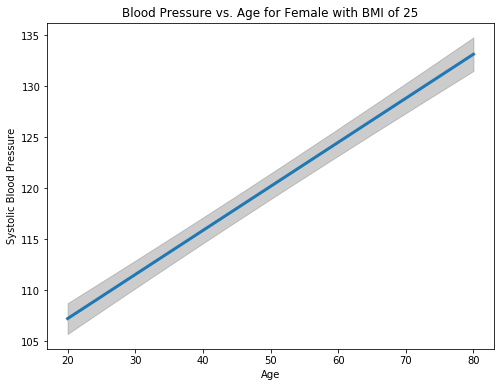

In [47]:
# Import predict_functional
from statsmodels.sandbox.predict_functional import predict_functional

# Fix variables at specific values (we also include education, ethnicity, and smoking here to avoid error messages from predict_functional)
values = {"RIAGENDRx": "Female", "BMXBMI": 25, "DMDEDUC2x": "College", "RIDRETH1x": "Non Hisp White", "SMQ020x": "No"}

# The returned values are the predicted values (pv), confidence bands (cb), and function values (fv).
pv, cb, fv = predict_functional(result, "RIDAGEYR", values=values, ci_method="simultaneous")

plt.figure(figsize=(8, 6))
g = sns.lineplot(fv, pv, lw=3)
g.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
g.set_title("Blood Pressure vs. Age for Female with BMI of 25")
g.set_xlabel("Age")
g.set_ylabel("Systolic Blood Pressure")

This time, let's plot systolic blood pressure vs. BMI for women aged 40. Our dependent variable is already set as systolic blood pressure (BPXSY2). We'll set our independent focus variable as BMI as we're plotting blood pressure vs. BMI. We'll set our gender to female and age to 40. You can see that the shaded gray confidence bounds are wider meaning that the relationship between blood pressure and BMI has less certainty than that between blood pressure and age. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'SDMVPSU', 'SDMVSTRA', 'INDFMPIR' in data frame but not in summaries or values.
  ValueWarning)


Text(0, 0.5, 'Systolic Blood Pressure')

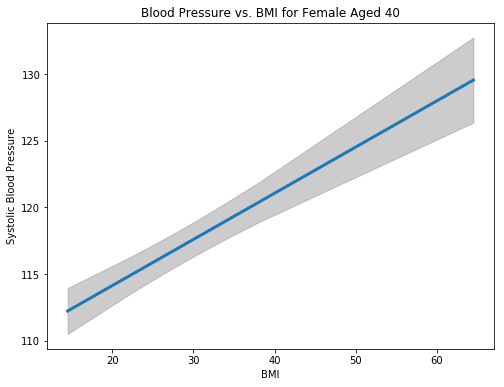

In [48]:
values = {"RIAGENDRx": "Female", "RIDAGEYR": 40, "DMDEDUC2x": "College", "RIDRETH1x": "Non Hisp White", "SMQ020x": "No"}
pv, cb, fv = predict_functional(result, "BMXBMI", values=values, ci_method="simultaneous")

plt.figure(figsize=(8, 6))
g = sns.lineplot(fv, pv, lw=3)
g.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
g.set_title("Blood Pressure vs. BMI for Female Aged 40")
g.set_xlabel("BMI")
g.set_ylabel("Systolic Blood Pressure")

## Part 3: Variance Structure 

#### Mean-variance relationship 

Let's visualize the variance structure of the population from our linear model by plotting residuals against fitted values. We can see the mean-variance relationship from our scatterplot: variance around mean blood pressure increases when blood pressure increases (heteroscedasticity). 

Text(0, 0.5, 'Residuals')

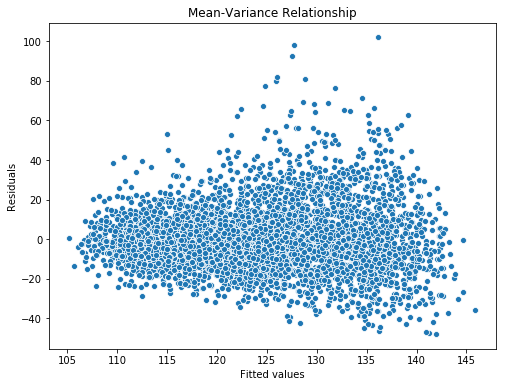

In [49]:
# Plot mean-variance relationship of residuals vs. fitted values
plt.figure(figsize=(8, 6))
g = sns.scatterplot(result.fittedvalues, result.resid)
g.set_title("Mean-Variance Relationship")
g.set_xlabel("Fitted values")
g.set_ylabel("Residuals")

#### Partial residual plots 

We can also use a component and component plus residual (CCPR) plot, or partial residual plot, which is essentially a synthetic data set removing the effects of all but one variable. We'll see how variance looks like if one independent focus variable is allowed to change while all other independent variables and unexplained variation is fixed. Explained variation can be seen in the yellow trendline while unexplained variation is seen in the scatter around the trendline. 

First, let's import plot_ccpr from statsmodels.graphics.regressionplots. Let's plot our dependent variable blood pressure residuals on the y axis, set our independent focus variable as age (allowed to change) on the x axis, and fix gender, BMI, education, and ethnicity. From our CCPR plot, we see that if gender, BMI, education, and ethnicity are fixed and our focus variable age is allowed to change, the mean systolic blood pressure of an 80-year-old and an 18-year-old differs by 30 mmHg.    

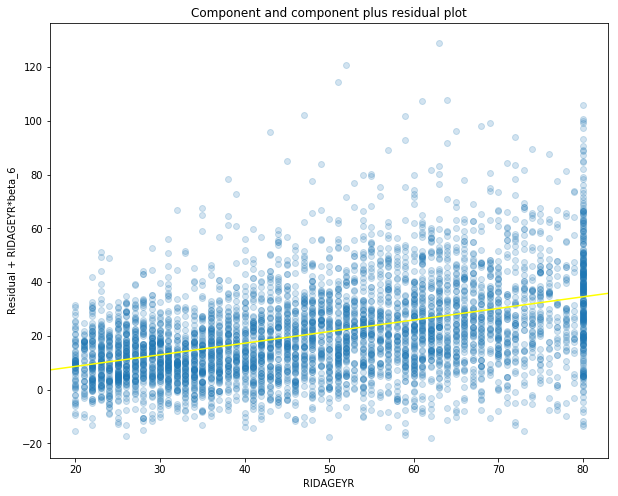

In [50]:
# Import plot_ccpr from statsmodels.graphics.regressionplots 
from statsmodels.graphics.regressionplots import plot_ccpr

# Partial residual plot using ages as the focus variable
plt.figure(figsize=(10, 8))
ax = plt.axes()
plot_ccpr(result, "RIDAGEYR", ax)
ax.lines[0].set_alpha(0.2)
ax.lines[1].set_color('yellow')

Let's plot another partial residual plot, this time using BMI as our independent focus variable (allowed to change) and fixing gender, age, education, and ethnicity. This time we see greater scatter (unexplained variation) and the variance is not as uniformly distributed as they were for age. Though there is a clear trendline, BMI does not seem as good a predictor for systolic blood pressure as does age. 

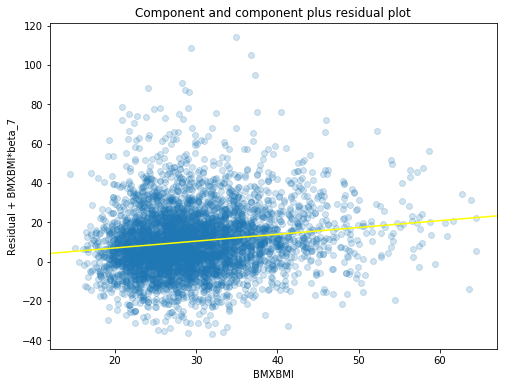

In [51]:
# Partial residual plot using BMI as the focus variable
plt.figure(figsize=(8, 6))
ax = plt.axes()
plot_ccpr(result, "BMXBMI", ax)
ax.lines[0].set_alpha(0.2)
ax.lines[1].set_color("yellow")

#### Added variable plot

After seeing the mean-variance relationship of blood pressure residuals vs. age above, let's construct an added variable plot to check for non-linearity in the relationship between systolic blood pressure and age. 

First, let's import add_lowess from statsmodels.graphics.regressionplots. In order to construct the added variable plot, we'll first need to fit a a generalized linear model (GLM), an equivalent way of fitting a linear regression model (to OLS above), and then set the figure using result.plot_added_variable with our added variable being age (RIDAGEYR). Importantly, note that blood pressure and age have been centered around their respective means. 

The red trendline is not forced to be linear. Here, we can see that the trendline is flatter when people are in their 20s and 30s and curves upward as people get older. The curvature isn't that extreme, but, if it were, we could consider non-linear modeling adjustments to age (e.g., parabolic, variable relationships). 

<Figure size 576x432 with 0 Axes>

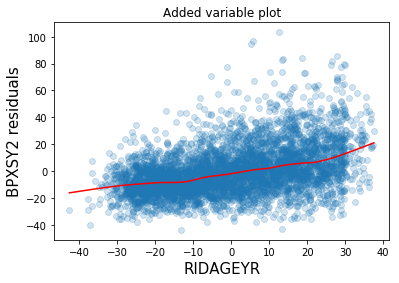

In [52]:
# This is not part of the main Statsmodels API, so needs to be imported separately
from statsmodels.graphics.regressionplots import add_lowess

model = sm.GLM.from_formula("BPXSY2 ~ RIDAGEYR + RIAGENDRx + BMXBMI + DMDEDUC2x + RIDRETH1x", data=health)
result = model.fit()
result.summary()

# Added variable plot with age as our added variable
plt.figure(figsize=(8, 6))
fig = result.plot_added_variable("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
_ = add_lowess(ax)

## Part 4: Marginal Linear Model 

NHANES follows a complex sampling design, specifically geographic cluster sampling. You can learn more here (https://www.cdc.gov/nchs/tutorials/nhanes/SurveyDesign/SampleDesign/Info1.htm). In the sampling design, primary sampling units (SDMVPSU) include counties, which are then divided into subregions, from which households are drawn and individuals are sampled. In order to pretect individuals' confidentiality, masked variance units (SDMVSTRA) combine subregions of different counties to mimic contiguous subregions. While they're not the actual original clusters, they can be treated as proxies of the original clusters with variances that closely approximate those of the original true design. We can arrive at their identifiers by combining them. 

In [53]:
# Form cluster variable 
health["cluster"] = 10*health.SDMVSTRA + health.SDMVPSU

Let's fit a marginal linear regression model, specifically a generalized estimating equation (GEE). For our working correlation matrix, let's use exchangeable, which assumes constant correlation of observations within a cluster. 

We see that we have a within-cluster correlation of 0.021. While it seems low, it's not directly comparable to a Pearson correlation and is actually fairly high (0 means perfect independence while 1 means perfect clustering where values are identical). 

In [54]:
# Within-cluster correlation using GEE without covariates, only an intercept ("~1"), and exchangeable correlation structure. 
model = sm.GEE.from_formula("BPXSY2 ~ 1", groups="cluster", cov_struct=sm.cov_struct.Exchangeable(), data=health)
result = model.fit()
print(result.cov_struct.summary())

The correlation between two observations in the same cluster is 0.021


Let's do the same but now more variables and a similar exchangeable correlation structure. We also see non-negligible within-cluster correlation for observations of blood pressure, age, and BMI. 

In [55]:
# Within-cluster correlation of multiple variables using GEE without covariates, only an intercept (""~1"), and exchangeable correlation structure. 
for v in ["BPXSY2", "RIDAGEYR", "BMXBMI"]:
    model = sm.GEE.from_formula(v + " ~ 1", groups="cluster", cov_struct=sm.cov_struct.Exchangeable(), data=health)
    result = model.fit()
    print(v, result.cov_struct.summary())

BPXSY2 The correlation between two observations in the same cluster is 0.021
RIDAGEYR The correlation between two observations in the same cluster is 0.038
BMXBMI The correlation between two observations in the same cluster is 0.040


Above, we looked at within cluster correlation of specific variables without covariates using only an intercept. Let's look at within-cluster correlation of systolic blood pressure with covariates, that is, controlling for other variables, in this case, age. This can be useful since we know from our earlier analyses that older people have higher blood pressure and some geographic clusters clusters may be older than others. 

Since we're controlling for age, as we'd expect, the within-cluster correlation for blood pressure drops from 0.021 above to 0.013. 

In [56]:
# Within-cluster correlation of blood pressure controlling for age using GEE and exchangeable correlation structure
model = sm.GEE.from_formula("BPXSY2 ~ RIDAGEYR", groups="cluster", cov_struct=sm.cov_struct.Exchangeable(), data=health)
result = model.fit()
print(result.cov_struct.summary())

The correlation between two observations in the same cluster is 0.013


Let's do the same now controlling for more variables, including age, gender, BMI, education, and ethnicity. The within-cluster correlation for blood pressure drops further to 0.010. 

In [57]:
# Within-cluster correlation of blood pressure controlling for age, gender, BMI, education and ethnicity using GEE and exchangeable correlation structure
# Note that for categorical variables gender, education, and ethnicity, we've already reassigned codes to values. If we had not already done that
# these codes would be considered quantitiative data and we would need to use "C()" syntax below (e.g., C(DMDEDUC2x)) for them to be treated as categorical
model = sm.GEE.from_formula("BPXSY2 ~ RIDAGEYR + RIAGENDRx + BMXBMI + DMDEDUC2x + RIDRETH1x", groups="cluster", cov_struct=sm.cov_struct.Exchangeable(), data=health)
result = model.fit()
print(result.cov_struct.summary())

The correlation between two observations in the same cluster is 0.010


Now that we've confirmed within-cluster correlation, let's fit both the OLS and marginal (GEE) models. Let's construct a table to compare parameters and standard error between the two models for all of our variables. Since OLS doesn't take into account the within-cluster correlation that we found, it will often underrepresent standard error. As expected, GEE standard errors are often higher than those of the OLS model. 

Since we know that there are within-cluster dependencies, an OLS model is not justified and the GEE model is a superior fit with more accurate and meaningful parameters and standard errors (assuming exclusively within-cluster and not between-cluster dependencies).   

In [58]:
# Fit OLS linear model
OLS = sm.OLS.from_formula("BPXSY2 ~ RIDAGEYR + RIAGENDRx + BMXBMI + DMDEDUC2x + RIDRETH1x", data=health)
result_OLS = OLS.fit()

# Fit marginal (GEE) linear model
marginal = sm.GEE.from_formula("BPXSY2 ~ RIDAGEYR + RIAGENDRx + BMXBMI + DMDEDUC2x + RIDRETH1x", groups="cluster", cov_struct=sm.cov_struct.Exchangeable(), data=health)
result_marginal = marginal.fit()

# Create dataframe for comparing OLS and GEE parameters and standard errors
compare = pd.DataFrame({"OLS Params": result_OLS.params, "OLS SE": result_OLS.bse, "GEE Params": result_marginal.params, "GEE SE": result_marginal.bse})
compare = compare[["OLS Params", "OLS SE", "GEE Params", "GEE SE"]]

# Print out the results in a pretty way
display(HTML(compare.to_html()))

,OLS Params,OLS SE,GEE Params,GEE SE
Intercept,88.861551,1.455365,88.967899,1.467589
RIAGENDRx[T.Male],3.577294,0.474152,3.552894,0.457785
DMDEDUC2x[T.Elementary],3.519659,0.916960,3.593066,0.924697
DMDEDUC2x[T.HS],2.533339,0.700576,2.419768,0.718166
DMDEDUC2x[T.Middle],3.141083,0.863685,2.956329,0.942382
DMDEDUC2x[T.SomeCollege],1.458078,0.645504,1.332722,0.591608
RIDRETH1x[T.Non Hisp Black],5.252856,0.804733,5.030447,1.168218
RIDRETH1x[T.Non Hisp White],-0.538700,0.756160,-0.680170,0.925944
RIDRETH1x[T.Other],1.174877,0.888453,1.248505,0.927596
RIDRETH1x[T.Other Hisp],0.419413,0.877361,-0.349622,0.851486


## Part 5: Multilevel Linear Model 

We've taken into account within-cluster dependencies with marginal modeling above. Now let's look at between-cluster variation using a multilevel linear model (aka hierarchical model, mixed effects model). While our marginal model above allows us to make generalized conclusions across all of our clusters, a multilevel model allows to draw different conclusions for each cluster by pointing out random effects and allowing coefficients to vary by cluster. For example, blood pressure may tend to be 1 mmHg higher in one geographic cluster compared to another and this information can be used to predict blood pressure in that cluster. 

Keep in mind that our multilevel model below focuses only on random intercepts and not random slopes, meaning that data from each cluster is shifted by a common amount. In addtion to the below, we can look at how slopes of each covariate varies by cluster (random slopes), that is, how the rate at which blood pressure increase varies by cluster.   

From our multilevel model results, we see that the model has converged and that we have 30 clusters each with a mean size of roughly 156 people. Our unexplained variance ("scale" in the top right) is 257.7. The variance of our clusters ("cluster Var" in the bottom) is 2.449. If were to choose two clusters, their randmom effects on systolic blood pressure would differ by 2.21 mmHg (calculated by taking the square root of 2 times the cluster variance of 2.449). This between cluster differece is quite large, in fact, almost as large as 5 years of aging. 

To calculate our between-cluster correlation, we take our cluster variance of 2.449 and divide it by the sum of the cluster variance (2.449) and the unexplained variance (257.7) to get 0.009, which is close to the within-cluster correlation of 0.010 we got earlier in our marginal model.  

In [59]:
# Fit multilevel (mixed effects) linear model 
model = sm.MixedLM.from_formula("BPXSY2 ~ RIDAGEYR + RIAGENDRx + BMXBMI + DMDEDUC2x + RIDRETH1x", groups="cluster", data=health)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM     Dependent Variable:     BPXSY2     
No. Observations:      4692        Method:                 REML       
No. Groups:            30          Scale:                  257.6738   
Min. group size:       99          Likelihood:             -19690.6590
Max. group size:       214         Converged:              Yes        
Mean group size:       156.4                                          
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   88.967    1.507 59.037 0.000 86.014 91.921
RIAGENDRx[T.Male]            3.553    0.473  7.516 0.000  2.626  4.480
DMDEDUC2x[T.Elementary]      3.593    0.924  3.888 0.000  1.781  5.404
DMDEDUC2x[T.HS]              2.420    0.705  3.431 0.001  1.038  3.803
DMDEDUC2x[T.Middle]          2.957    0.871  3.394 0.001  1.249  4.665
DMDEDUC2x[T.SomeCollege]     1.333    0.650  2.051 0.040  0.059  2.608
RIDRETH1x[T.Non Hisp Black]  5.031    0.889  5.662 0.000  3.290  6.773
RIDRETH1x[T.Non Hisp White] -0.680    0.824 -0.824 0.410 -2.295  0.936
RIDRETH1x[T.Other]           1.248    0.945  1.320 0.187 -0.604  3.100
RIDRETH1x[T.Other Hisp]     -0.347    0.941 -0.368 0.713 -2.191  1.498
RIDAGEYR                     0.438    0.014 31.210 0.000  0.410  0.465
BMXBMI                       0.341    0.035  9.858 0.000  0.273  0.408
cluster Var                  2.449    0.068                           
======================================================================

"""

Let's look at the predicted random effects, or best linear unbiased predictions (BLUPs), for each of the 30 clusters, which tells us how unique each county is relative to the mean. Keep in mind, that these random effects are expected after adjusting for each of our 5 covariates, meaning that they are due to specific characteristics of each geographic cluster. We see that cluster 1241 has an unusually high blood pressure, while cluster 1282 has an unusually low blood pressure. 

In [60]:
result.random_effects

{1191: cluster   -1.647173
 dtype: float64, 1192: cluster    0.078556
 dtype: float64, 1201: cluster   -1.423481
 dtype: float64, 1202: cluster    0.022299
 dtype: float64, 1211: cluster    0.37911
 dtype: float64, 1212: cluster    0.985307
 dtype: float64, 1221: cluster    0.970659
 dtype: float64, 1222: cluster   -0.221739
 dtype: float64, 1231: cluster   -1.757244
 dtype: float64, 1232: cluster    0.851174
 dtype: float64, 1241: cluster    3.211731
 dtype: float64, 1242: cluster   -0.597378
 dtype: float64, 1251: cluster    0.507824
 dtype: float64, 1252: cluster    1.376976
 dtype: float64, 1261: cluster   -0.5395
 dtype: float64, 1262: cluster    0.066413
 dtype: float64, 1271: cluster    0.238483
 dtype: float64, 1272: cluster   -0.485663
 dtype: float64, 1281: cluster   -0.532182
 dtype: float64, 1282: cluster   -2.113257
 dtype: float64, 1291: cluster   -1.874488
 dtype: float64, 1292: cluster   -1.314736
 dtype: float64, 1301: cluster   -0.522872
 dtype: float64, 1302: cluster

Now let's compare the parameters and standard errors for all three models - OLS, GEE, and MLM. As expected, OLS features a lower standard error for many variables compared to GEE and MLM as it doesn't take into account within-cluster dependencies and between-cluster variance. 

In [61]:
# Create dataframe for comparing OLS, GEE, and MLM parameters and standard errors
compare = pd.DataFrame({"OLS Params": result_OLS.params, "OLS SE": result_OLS.bse, "GEE Params": result_marginal.params, "GEE SE": result_marginal.bse, "MLM Params": result.params, "MLM SE": result.bse})
compare = compare[["OLS Params", "OLS SE", "GEE Params", "GEE SE", "MLM Params", "MLM SE"]]

# Print out the results in a pretty way
display(HTML(compare.to_html()))

,OLS Params,OLS SE,GEE Params,GEE SE,MLM Params,MLM SE
BMXBMI,0.335554,0.034464,0.340743,0.038499,0.340723,0.034565
DMDEDUC2x[T.Elementary],3.519659,0.916960,3.593066,0.924697,3.592837,0.924194
DMDEDUC2x[T.HS],2.533339,0.700576,2.419768,0.718166,2.420379,0.705353
DMDEDUC2x[T.Middle],3.141083,0.863685,2.956329,0.942382,2.957239,0.871321
DMDEDUC2x[T.SomeCollege],1.458078,0.645504,1.332722,0.591608,1.333355,0.650203
Intercept,88.861551,1.455365,88.967899,1.467589,88.967405,1.506970
RIAGENDRx[T.Male],3.577294,0.474152,3.552894,0.457785,3.552993,0.472733
RIDAGEYR,0.439236,0.013922,0.437732,0.019083,0.437738,0.014025
RIDRETH1x[T.Non Hisp Black],5.252856,0.804733,5.030447,1.168218,5.031283,0.888585
RIDRETH1x[T.Non Hisp White],-0.538700,0.756160,-0.680170,0.925944,-0.679571,0.824400
